# mask R-CNN 학습

텐서 플로우 버전 **2.5.0** 인지 확인  
텐서 플로우 2.5.0 버전에서만 구동 가능

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

GPU 확인

In [3]:
!nvidia-smi

Fri Aug 23 01:25:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:65:00.0 Off |                   On |
| N/A   40C    P0              69W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

**Mask R-CNN 소스코드 클론 (이미 되어있으면 할 필요 x)**

In [3]:
 !git clone https://github.com/kairess/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


현재 위치 확인

In [1]:
!pwd

/home/elicer/parking_project/tyhsin/parking


**mask-rcnn 소스 파일(Mask_RCNN 폴터)을 경로를 root 경로로 지정**

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

ROOT_DIR = '/home/elicer/parking_project/tyhsin/parking/Mask_RCNN'

sys.path.append(ROOT_DIR)
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

2024-08-26 06:22:36.428416: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


**사전학습 모델 다운로드 (coco 가중치)**  
Mask_RCNN 디렉토리 내부에 mask_rcnn_coco.h5 가중치 파일 다운로드

In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [3]:
class TrainConfig(Config):
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    LEARNING_RATE = 0.001

    # Number of classes (including background)
    NUM_CLASSES = 1 + 16  # background + 8 (Car,Van,Other Vehicle,Traffic Pole,Parking Block,Parking Sign,Driveable Space,Disabled Parking Space)


    # All of our training images are 1920x1012
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50' # resnet50

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                29
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

**데이터셋을 coco형식으로 불러오기 위한 클래스 정의**

In [8]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                print('image_id', image_id)
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids

**Dataset Load 및 시각화**

In [9]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/home/elicer/parking_project/dataset/data/label/train.json', '/home/elicer/parking_project/dataset/data/source')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/elicer/parking_project/dataset/data/label/val.json', '/home/elicer/parking_project/dataset/data/source')
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 4)

print('Train', len(dataset_train.image_ids))
print('Validation', len(dataset_val.image_ids))

print("Train data")
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_val_ids = np.random.choice(dataset_val.image_ids, 4)
print("Validation data")
for image_id in image_val_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

image_id 10498


KeyError: 10498

**Training 모델 제작**

In [7]:
model = modellib.MaskRCNN(
    mode="training",
    config=config,
    model_dir=MODEL_DIR)

model.load_weights(
    COCO_MODEL_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2024-08-26 04:53:51.154791: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-08-26 04:53:51.307814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA A100 80GB PCIe MIG 3g.40gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 42 deviceMemorySize: 39.25GiB deviceMemoryBandwidth: 901.22GiB/s
2024-08-26 04:53:51.307861: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-08-26 04:53:51.329514: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-08-26 04:53:51.329597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-08-26 04:53:51.332838: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libr

In [ ]:
import tensorflow as tf
print("Is TensorFlow using GPU?", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is TensorFlow using GPU? True


2024-08-21 09:44:49.798337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA A100 80GB PCIe MIG 3g.40gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 42 deviceMemorySize: 39.25GiB deviceMemoryBandwidth: 901.22GiB/s
2024-08-21 09:44:49.800736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-08-21 09:44:49.800769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-21 09:44:49.800779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2024-08-21 09:44:49.800786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2024-08-21 09:44:49.803180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device (/device:GPU:0 with 38435 MB memory) -> physical GPU (device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:65:00.0, compute 

**Head 만 학습 시키고 나머지는 동결**  
layers =  옵션을 'all'로 하면 전체 layer를 학습 시킬 수 있음

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()

model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=10,
    layers='heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/elicer/parking_project/tyhsin/parking/Mask_RCNN/logs/custom20240826T0253/mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDi

/home/elicer/anaconda3/envs/maskrcnn/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/elicer/anaconda3/envs/maskrcnn/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradient

 1/30 [>.............................] - ETA: 2:57 - batch: 0.0000e+00 - size: 5.0000 - loss: 10.3233 - rpn_class_loss: 2.1189 - rpn_bbox_loss: 2.4994 - mrcnn_class_loss: 3.9405 - mrcnn_bbox_loss: 0.9990 - mrcnn_mask_loss: 0.7655

2024-08-26 02:54:03.364319: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2024-08-26 02:54:03.364365: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2024-08-26 02:54:03.649220: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-08-26 02:54:03.650147: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2024-08-26 02:54:03.758164: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3897 callback api events and 3944 activity events. 
2024-08-26 02:54:03.853856: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2024-08-26 02:54:03.929519: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /home/elicer/parking_project/tyhsin/parking/Mask_RCNN/logs/custom20240826T0253/plugins/profile/2024_08_26_02_54_03
2024-08-26 02:54:04.008968: I tenso

 2/30 [=>............................] - ETA: 36s - batch: 0.5000 - size: 5.0000 - loss: 8.8622 - rpn_class_loss: 1.5042 - rpn_bbox_loss: 2.2150 - mrcnn_class_loss: 3.5460 - mrcnn_bbox_loss: 0.8784 - mrcnn_mask_loss: 0.7187      

2024-08-26 02:54:04.114074: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /home/elicer/parking_project/tyhsin/parking/Mask_RCNN/logs/custom20240826T0253/plugins/profile/2024_08_26_02_54_03
2024-08-26 02:54:04.124663: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /home/elicer/parking_project/tyhsin/parking/Mask_RCNN/logs/custom20240826T0253/plugins/profile/2024_08_26_02_54_03/b9eda2405896.memory_profile.json.gz
2024-08-26 02:54:04.128346: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /home/elicer/parking_project/tyhsin/parking/Mask_RCNN/logs/custom20240826T0253/plugins/profile/2024_08_26_02_54_03Dumped tool data for xplane.pb to /home/elicer/parking_project/tyhsin/parking/Mask_RCNN/logs/custom20240826T0253/plugins/profile/2024_08_26_02_54_03/b9eda2405896.xplane.pb
Dumped tool data for overview_page.pb to /home/elicer/parking_project/tyhsin/parking/Mask

30/30 [==============================] - ETA: 0s - batch: 14.5000 - size: 5.0000 - loss: 3.1534 - rpn_class_loss: 0.2445 - rpn_bbox_loss: 1.4402 - mrcnn_class_loss: 0.5612 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.4009

/home/elicer/anaconda3/envs/maskrcnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1: F1 Score - None, Validation F1 Score - None
30/30 [==============================] - 67s 2s/step - batch: 14.5000 - size: 5.0000 - loss: 3.1534 - rpn_class_loss: 0.2445 - rpn_bbox_loss: 1.4402 - mrcnn_class_loss: 0.5612 - mrcnn_bbox_loss: 0.5065 - mrcnn_mask_loss: 0.4009 - val_loss: 3.7456 - val_rpn_class_loss: 0.1256 - val_rpn_bbox_loss: 2.0205 - val_mrcnn_class_loss: 0.4353 - val_mrcnn_bbox_loss: 0.6139 - val_mrcnn_mask_loss: 0.5504
Epoch 2/10
30/30 [==============================] - 43s 1s/step - batch: 14.5000 - size: 5.0000 - loss: 1.6712 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.9351 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.2456 - val_loss: 3.5802 - val_rpn_class_loss: 0.1425 - val_rpn_bbox_loss: 1.8229 - val_mrcnn_class_loss: 0.5584 - val_mrcnn_bbox_loss: 0.5089 - val_mrcnn_mask_loss: 0.5475
Epoch 3/10
30/30 [==============================] - 45s 2s/step - batch: 14.5000 - size: 5.0000 - loss: 1.3189 - rpn_class_loss: 0.0302 - rpn_bbox

In [17]:
print(history.history)

{'loss': [3.1533782919247946, 1.6712402602036793, 1.3189431051413218, 1.1395057131846746, 0.9638701617717743, 0.9456951101620992, 0.8525591045618057, 0.8296261698007583, 0.767230502764384, 0.7447026958068211], 'rpn_class_loss': [0.2445483, 0.03616577, 0.030154262, 0.024602005, 0.021736102, 0.018308671, 0.015651036, 0.013566508, 0.013394091, 0.012755218], 'rpn_bbox_loss': [1.4401842, 0.93508106, 0.6946109, 0.6355514, 0.5132445, 0.5216848, 0.47187883, 0.4585212, 0.42540213, 0.41996822], 'mrcnn_class_loss': [0.5611966, 0.16700949, 0.12399862, 0.110501796, 0.0919241, 0.081120305, 0.080332145, 0.087128125, 0.076435655, 0.066343494], 'mrcnn_bbox_loss': [0.5065122, 0.28736493, 0.23360112, 0.18316597, 0.15941082, 0.1499735, 0.12836252, 0.113828816, 0.1037764, 0.104041055], 'mrcnn_mask_loss': [0.40093702, 0.24561915, 0.23657826, 0.18568455, 0.17755458, 0.1746078, 0.15633453, 0.15658154, 0.14822221, 0.14159472], 'val_loss': [3.745617911219597, 3.5802232325077057, 3.816151440143585, 3.99261943995

## detection 평가

In [53]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85
    USE_MINI_MASK = False #평가할 때 미니 마스크 사용을 해제해야 함

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference",
    config=inference_config,
    model_dir=MODEL_DIR)

model_path = test_model.find_last()
print(model_path)
output_dir = './results'
# 디렉토리 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

test_model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                29
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

image ID: coco_like.17 (16) 
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 29)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
gt_class_id              shape: (11,)                 min:   14.00000  max:   16.00000  int32
gt_bbox                  shape: (11, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 11)        min:    0.00000  max:    1.00000  bool
pred_mask                shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool


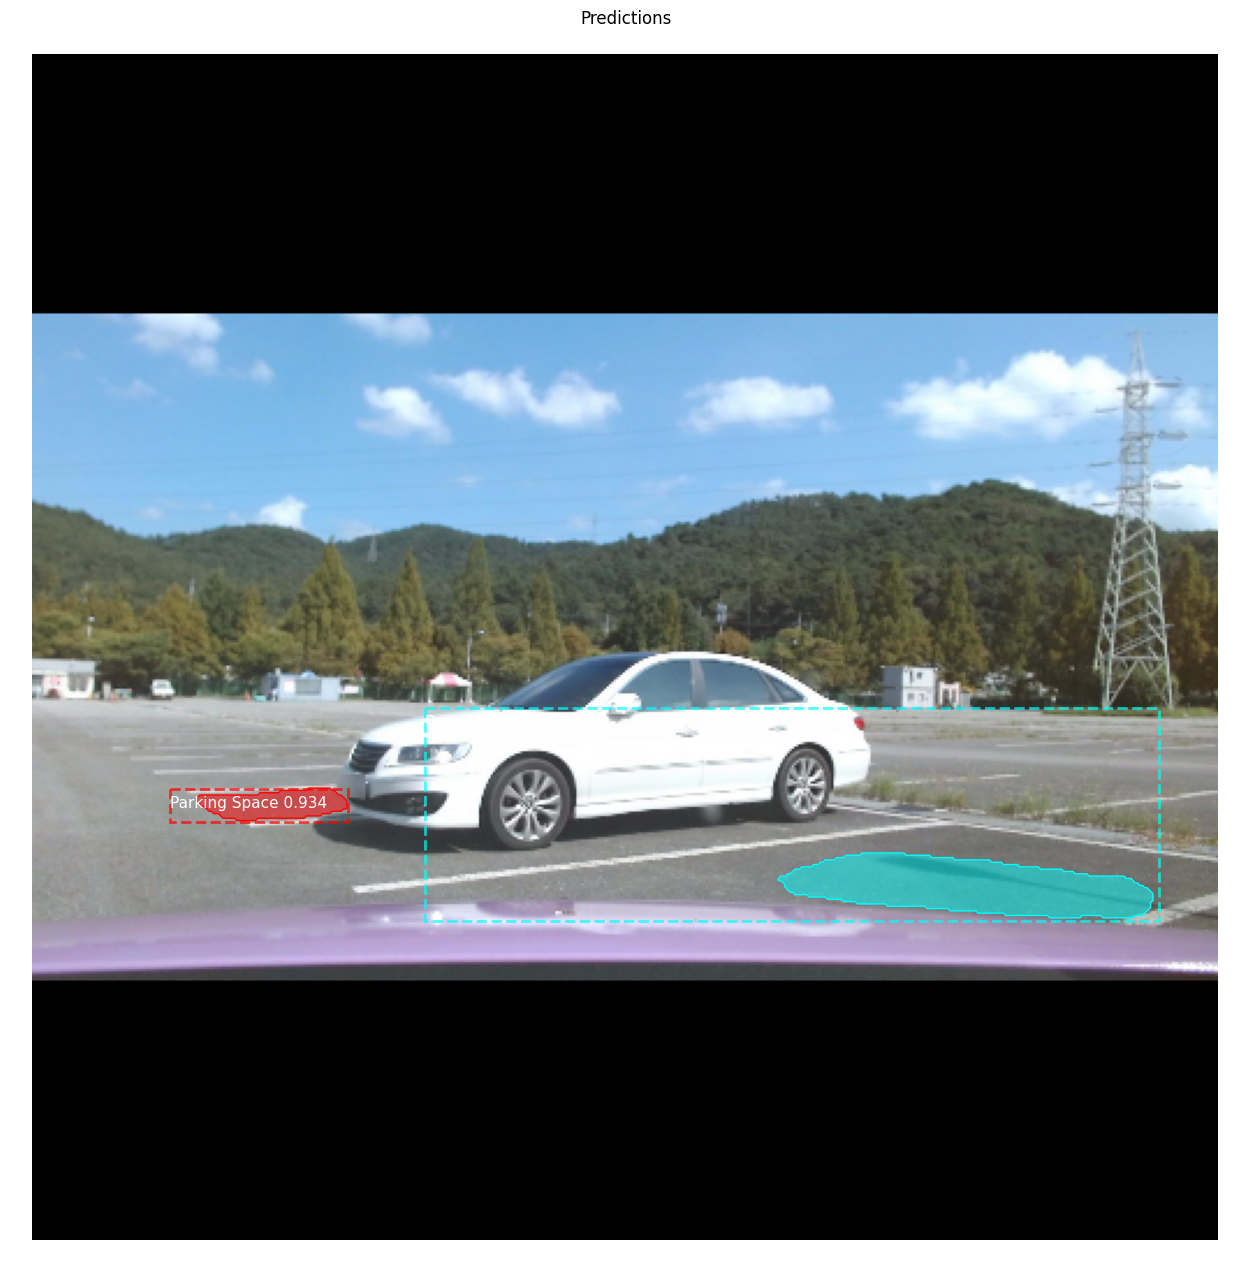

In [70]:
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mrcnn.model import log

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, augmentation=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
# Run object detection
results = test_model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("pred_mask", r['masks'])

In [55]:
print(f"gt_masks shape: {gt_mask.shape}")
print(f"pred_masks shape: {r['masks'].shape}")

gt_masks shape: (512, 512, 18)
pred_masks shape: (512, 512, 2)


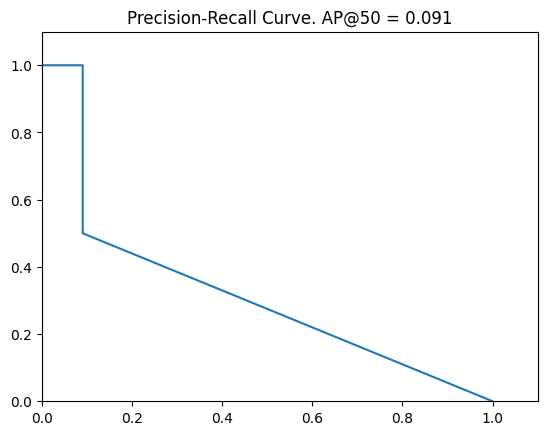

In [71]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

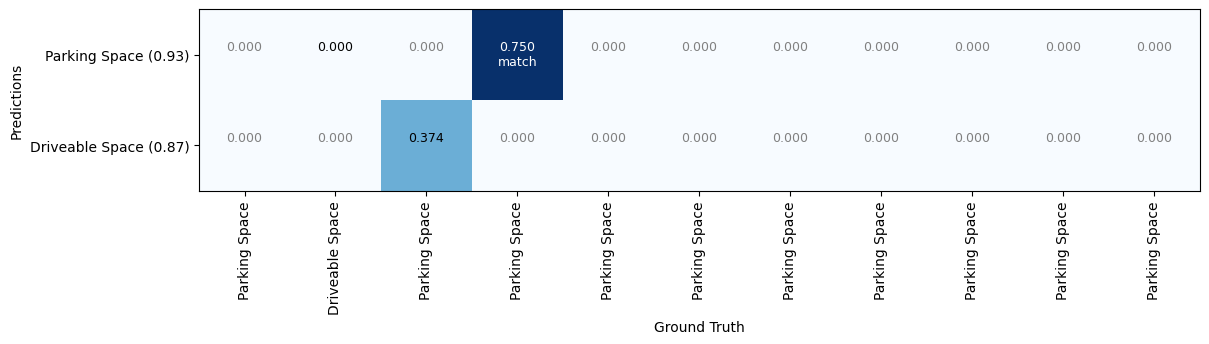

In [72]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

In [73]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, augmentation = False)
        # Run object detection
        results = test_model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.10382319639126458


In [14]:
import skimage
import cv2

real_test_dir = '/home/elicer/parking_project/dataset/data/실외_대형주차장/source/'
image_paths = []
class_names = ["a","a","a","a","a","a","a","a","a","a","a","a","a","a","BG", "Parking Space", "Drivable Space"]



for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
# OpenCV를 사용하여 감지 결과를 이미지에 그리고 저장
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):  # 채널에 대해 반복
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_results(image, boxes, masks, class_ids, class_names, scores, output_path):
    n_instances = boxes.shape[0]
    if not n_instances:
        print('No instances found!')
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(n_instances):
        box = boxes[i]
        mask = masks[:, :, i]
        class_id = class_ids[i]
        score = scores[i]
        color = np.random.rand(3)

        # 마스크 적용
        image = apply_mask(image, mask, color)
        
        # 바운딩 박스 그리기
        y1, x1, y2, x2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), color * 255, 2)

        # 클래스 및 점수 표시
        label = f"{class_names[class_id]}: {score:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color * 255, 1)

    # 이미지 저장
    cv2.imwrite(output_path, image[..., ::-1])

# 결과를 생성하고 저장
for idx, image_path in enumerate(image_paths):  # 처리할 이미지의 수 지정
    start_time = time.time()
    image = skimage.io.imread(image_path)
    results = test_model.detect([image], verbose=1)
    end_time = time.time()
    take_time = end_time -start_time
    print(f'{take_time} 초 걸렸습니다.')
    r = results[0]

    # 결과 이미지 경로 설정
    output_path = os.path.join(output_dir, f"result_{idx}.jpg")

    # 결과 이미지 생성 및 저장
    display_results(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], output_path)
    
print("Results saved in", output_dir)

# for image_path in image_paths:
#     img = skimage.io.imread(image_path)
#     img_arr = np.array(img)

#     results = test_model.detect([img_arr], verbose=1)
#     r = results[0]
#     print(r['class_ids'])
#     colors = tuple(np.take(mask_colors, r['class_ids'], axis=0))

#     visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
#                                 dataset_val.class_names, r['scores'], figsize=(16, 8),
#                                 colors=colors)

Processing 1 images
image                    shape: (1080, 1920, 3)       min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 29)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
0.2248985767364502 초 걸렸습니다.
Processing 1 images
image                    shape: (1080, 1920, 3)       min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 29)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
0.20775794982910156 초 걸렸습니다.
Processing 1 images
image                    shape: (1080, 1920, 3)       min:   27.00000  max:  255.00000  uint8
molded_images            

KeyboardInterrupt: 

In [14]:
import cv2
import numpy as np

# RGB 값을 0~255 범위로 변환
mask_colors_255 = [
    (int(0.7478 * 255), int(0.1905 * 255), int(0.1024 * 255)),
    (int(0.0357 * 255), int(0.9180 * 255), int(0.8264 * 255)),
    (int(0.8963 * 255), int(0.2238 * 255), int(0.1020 * 255)),
    (int(0.5713 * 255), int(0.8911 * 255), int(0.5039 * 255)),
    (int(0.4640 * 255), int(0.8664 * 255), int(0.4757 * 255)),
    (int(0.4917 * 255), int(0.2390 * 255), int(0.2917 * 255)),
    (int(0.0816 * 255), int(0.8547 * 255), int(0.3956 * 255)),
    (int(0.5289 * 255), int(0.3895 * 255), int(0.1746 * 255)),
    (int(0.1121 * 255), int(0.1887 * 255), int(0.9756 * 255)),
    (int(0.7317 * 255), int(0.3119 * 255), int(0.7887 * 255)),
    (int(0.9913 * 255), int(0.6568 * 255), int(0.5528 * 255)),
    (int(0.7039 * 255), int(0.3766 * 255), int(0.5938 * 255)),
    (int(0.9814 * 255), int(0.3199 * 255), int(0.9073 * 255)),
    (int(0.7895 * 255), int(0.3670 * 255), int(0.5365 * 255)),
    (int(0.3384 * 255), int(0.6230 * 255), int(0.7162 * 255)),
    (int(0.6366 * 255), int(0.2260 * 255), int(0.2764 * 255)),
    (int(0.1462 * 255), int(0.1430 * 255), int(0.6033 * 255))
]
class_names = ["a","a","a","a","a","a","a","a","a","a","a","a","a","a","BG", "Parking Space", "Drivable Space"]


cap = cv2.VideoCapture('/home/elicer/parking_project/tyhsin/parking/output_video.mp4')

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), 
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):  # 채널에 대해 반복
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_results(image, boxes, masks, class_ids, class_names, scores):
    n_instances = boxes.shape[0]
    if not n_instances:
        print('No instances found!')
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(n_instances):
        box = boxes[i]
        mask = masks[:, :, i]
        class_id = class_ids[i]
        score = scores[i]
        color = np.random.rand(3)

        # 마스크 적용
        image = apply_mask(image, mask, color)
        
        # 바운딩 박스 그리기
        y1, x1, y2, x2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), color * 255, 2)

        # 클래스 및 점수 표시
        label = f"{class_names[class_id]}: {score:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color * 255, 1)
        
        
        
        
while cap.isOpened():
    ret, img = cap.read()

    if not ret:
        break

    results = test_model.detect([img])

    rois = results[0]['rois']
    class_ids = results[0]['class_ids']
    scores = results[0]['scores']
    masks = results[0]['masks']

    result_img = img.copy()
    
    results = test_model.detect([result_img], verbose=1)
    r = results[0]

    # 결과 이미지 생성 및 저장
    display_results(result_img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

    out.write(result_img)

cap.release()
out.release()


Processing 1 images
image                    shape: (1080, 1920, 3)       min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 29)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Processing 1 images
image                    shape: (1080, 1920, 3)       min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 29)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Processing 1 images
image                    shape: (1080, 1920, 3)       min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.1

In [ ]:
utils.compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5)